# Quadrotor Simulator

In order to easily simulate different algorithms, a simulation test bed must be created. This Python class deals with the plumbing between the controller, estimation, and the model of a quadrotor system. This notebook also provides abstract base classes for `Controller` and `Estimator`.

In [1]:
%%capture
%run quadrotor_model.ipynb
%run utils.ipynb
%run sensors.ipynb

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class Controller(object):
    """Controller
    """
    def __init__(self):
        self.name = "Manual"
    
    def __str__(self):
        return self.name
    
    def update(self, commanded, state, pkt, Ts):
        return np.array([[10, 0, 0, 0]]).T, commanded

In [4]:
class Estimator(object):
    """Estimator
    """
    def __init__(self, body=False):
        self.name = "Truth"
        
        # should the translational velocity be expressed
        # in the body-fixed frame or the inertial frame?
        self.body = body
        
    def __str__(self):
        return self.name
    
    def get_truth(self, quad):
        """Get Truth
        
        Obtain the true state from the simulated
        quadrotor object.
        """
        state = np.zeros((12,1))
        state[0:3] = quad.r
        state[3:6] = Rot_i_to_b(*quad.Phi.flatten()).dot(quad.v) if self.body else quad.v
        state[6:9] = quad.Phi
        state[9:12] = quad.omega
        return state
    
    def update(self, quad, u, Ts):
        """Update
        
        The default estimator is to use truth.
        """
        state = self.get_truth(quad)
        return state, state

In [5]:
class Commander(object):
    """Commander
    
    Allows the user to create flexible vehicle commands
    for the given controller. The default commander is
    a set point at 0.
    
    This class also allows the user to command any subset
    of vehicle states.
    """
    def __init__(self, default=False):
        # which subset of states should be commanded?
        self.pos = None
        self.vel = None
        self.Phi = None
        self.omega = None
        
        #
        # Default: Command everything to zero
        #
        
        if default:
            self.position(np.array([0.0, 0.0, 0.0]))
            self.velocity(np.array([None, None, None]))
            self.attitude(np.array([0.0, 0.0, 0.0]))
            self.angular_rates(np.array([None, None, None]))
        
    def position(self, pos):
        self.pos = pos
        
    def velocity(self, vel):
        self.vel = vel
        
    def attitude(self, Phi):
        self.Phi = Phi
        
    def angular_rates(self, omega):
        self.omega = omega
        
    def get_commands(self, i, Ts):
        pos = self.pos(i, Ts) if callable(self.pos) else self.pos
        Phi = self.Phi(i, Ts) if callable(self.Phi) else self.Phi
        commanded = np.hstack((pos, self.vel, Phi, self.omega))
        return commanded

In [6]:
class Simulator(object):
    """Simulator
        
    This class deals with the high-level simulation plumbing for a quadrotor system
    """
    def __init__(self, quad=None, ctrl=None, estm=None, cmdr=None, sens=None):
        self.quad = quad if quad else Quadrotor()
        self.ctrl = ctrl if ctrl else Controller()
        self.estm = estm if estm else Estimator()
        self.cmdr = cmdr if cmdr else Commander(default=True)
        self.sens = sens if sens else SensorManager()
        
        # Keep a history for plotting
        self.hist = {}
        
        # Simulation parameters
        self.Tf = 0
        self.Ts = 0
        self.N = 0
        
    def __str__(self):
        s  = "Simulation"
        return s

    def run(self, Tf, Ts=0.01):
        
        try:
            if _NO_SIM == True:
                return
        except Exception as e:
            pass
        
        # save simulation parameters
        self.Tf = Tf
        self.Ts = Ts
        
        # How many iterations are needed
        self.N = int(Tf/Ts)
        
        # quadrotor state
        state = truth = np.zeros((12,1))
        truth[0:3] = self.quad.r
        truth[3:6] = self.quad.v
        truth[6:9] = self.quad.Phi
        truth[9:12] = self.quad.omega
        
        # initialize data packet
        pkt = {}
        
        # initialize the plot history
        self.hist['u'] = np.zeros((4,self.N))
        self.hist['commanded'] = np.zeros((12,self.N))
        self.hist['state'] = np.zeros((12,self.N))
        self.hist['truth'] = np.zeros((12,self.N))
        
        #
        # Main Simulation Loop
        #
        
        for i in range(self.N):
            # determine the desired command
            commanded = self.cmdr.get_commands(i, Ts)
            
            # calculate control
            u, commanded = self.ctrl.update(commanded, truth, pkt, Ts)
                      
            # actuate physical model
            usat = self.quad.update(u, Ts)
            
            # read sensors
            pkt = self.sens.get_data_packet(self.quad, i, Ts)
            
            # run estimator
            state, truth = self.estm.update(self.quad, usat, Ts)
                
            # Update history
            self.hist['u'][:, i] = usat.flatten()
            self.hist['commanded'][:, i] = commanded.flatten()
            self.hist['state'][:, i] = state.flatten()
            self.hist['truth'][:, i] = truth.flatten()
    
    def plot(self):
        """Plot
        Create plot(s) of the evolution of the quadrotor state
        over the simulation horizon.
        """
        # Make sure that there is even data to plot
        if 'state' not in self.hist:
            return
        
        plt.ioff()
        fig = plt.figure(figsize=(12,10))
        fig.subplots_adjust(wspace=0.25)
        fig.suptitle('Vehicle State', fontsize=16)
        
        tvec = np.arange(self.N)*self.Ts
        
        #
        # Position
        #
        
        # for convenience
        xpos = self.hist['truth'][0, :]
        ypos = self.hist['truth'][1, :]
        zpos = self.hist['truth'][2, :]
        
        xcmd = self.hist['commanded'][0, :]
        ycmd = self.hist['commanded'][1, :]
        zcmd = self.hist['commanded'][2, :]
        
        ax = fig.add_subplot(6,2,1)
        if not np.isnan(xcmd).any():
            ax.plot(tvec, xcmd, 'r-', label='command')
        ax.plot(tvec, xpos, 'b-', label='truth')
        ax.set_ylabel('x'); ax.grid()
        ax.legend()

        ax = fig.add_subplot(6,2,3)
        if not np.isnan(ycmd).any():
            ax.plot(tvec, ycmd, 'r-', label='command')
        ax.plot(tvec, ypos, 'b-', label='truth')
        ax.set_ylabel('y'); ax.grid()
        
        ax = fig.add_subplot(6,2,5)
        if not np.isnan(zcmd).any():
            ax.plot(tvec, zcmd, 'r-', label='command')
        ax.plot(tvec, zpos, 'b-', label='truth')
        ax.set_ylabel('z'); ax.grid()
        
        #
        # Velocity
        #
        
        # for convenience
        xvel = self.hist['truth'][3, :]
        yvel = self.hist['truth'][4, :]
        zvel = self.hist['truth'][5, :]
        
        xvelhat = self.hist['state'][3, :]
        yvelhat = self.hist['state'][4, :]
        zvelhat = self.hist['state'][5, :]
        
        xcmd = self.hist['commanded'][3, :]
        ycmd = self.hist['commanded'][4, :]
        zcmd = self.hist['commanded'][5, :]
        
        ax = fig.add_subplot(6,2,2)
        if not np.isnan(xcmd).any():
            ax.plot(tvec, xcmd, 'r-', label='command')
        ax.plot(tvec, xvel, 'b-', label='truth')
        if not np.isnan(xvelhat).any() and self.estm.name != 'Truth':
            ax.plot(tvec, xvelhat, 'k:', label='estimate', linewidth=2)
        ax.set_ylabel('vx'); ax.grid()

        ax = fig.add_subplot(6,2,4)
        if not np.isnan(ycmd).any():
            ax.plot(tvec, ycmd, 'r-', label='command')
        ax.plot(tvec, yvel, 'b-', label='truth')
        if not np.isnan(yvelhat).any() and self.estm.name != 'Truth':
            ax.plot(tvec, yvelhat, 'k:', label='estimate', linewidth=2)
        ax.set_ylabel('vy'); ax.grid()
        
        ax = fig.add_subplot(6,2,6)
        if not np.isnan(zcmd).any():
            ax.plot(tvec, zcmd, 'r-', label='command')
        ax.plot(tvec, zvel, 'b-', label='truth')
        if not np.isnan(zvelhat).any() and self.estm.name != 'Truth':
            ax.plot(tvec, zvelhat, 'k:', label='estimate', linewidth=2)
        ax.set_ylabel('vz'); ax.grid()
        
        #
        # Attitude
        #
        
        # for convenience
        ph = self.hist['truth'][6, :]
        th = self.hist['truth'][7, :]
        ps = self.hist['truth'][8, :]
        
        phcmd = self.hist['commanded'][6, :]
        thcmd = self.hist['commanded'][7, :]
        pscmd = self.hist['commanded'][8, :]
        
        ax = fig.add_subplot(6,2,7)
        if not np.isnan(phcmd).any():
            ax.plot(tvec, np.degrees(phcmd), 'r-', label='command')
        ax.plot(tvec, np.degrees(ph), 'b-', label='truth')
        ax.set_ylabel(r'$\phi$'); ax.grid()

        ax = fig.add_subplot(6,2,9)
        if not np.isnan(thcmd).any():
            ax.plot(tvec, np.degrees(thcmd), 'r-', label='command')
        ax.plot(tvec, np.degrees(th), 'b-', label='truth')
        ax.set_ylabel(r'$\theta$'); ax.grid()
        
        ax = fig.add_subplot(6,2,11)
        if not np.isnan(pscmd).any():
            ax.plot(tvec, np.degrees(pscmd), 'r-', label='command')
        ax.plot(tvec, np.degrees(ps), 'b-', label='truth')
        ax.set_ylabel(r'$\psi$'); ax.grid()
        
        #
        # Angular Rates
        #
        
        # for convenience
        p = self.hist['truth'][9, :]
        q = self.hist['truth'][10, :]
        r = self.hist['truth'][11, :]

        pcmd = self.hist['commanded'][9, :]
        qcmd = self.hist['commanded'][10, :]
        rcmd = self.hist['commanded'][11, :]
        
        ax = fig.add_subplot(6,2,8)
        if not np.isnan(pcmd).any():
            ax.plot(tvec, pcmd, 'r-', label='command')
        ax.plot(tvec, p, 'b-', label='truth')
        ax.set_ylabel('p'); ax.grid()

        ax = fig.add_subplot(6,2,10)
        if not np.isnan(qcmd).any():
            ax.plot(tvec, qcmd, 'r-', label='command')
        ax.plot(tvec, q, 'b-', label='truth')
        ax.set_ylabel('q'); ax.grid()
        
        ax = fig.add_subplot(6,2,12)
        if not np.isnan(rcmd).any():
            ax.plot(tvec, rcmd, 'r-', label='command')
        ax.plot(tvec, r, 'b-', label='truth')
        ax.set_ylabel('r'); ax.grid()
        
        plt.show()
        
        #
        # Control Effort
        #
        
        thrust = self.hist['u'][0, :]
        tau_ph = self.hist['u'][1, :]
        tau_th = self.hist['u'][2, :]
        tau_ps = self.hist['u'][3, :]
        
        fig = plt.figure(figsize=(12,3))
        fig.subplots_adjust(wspace=0.25)
        fig.suptitle('Control Effort', fontsize=16)
        
        ax = fig.add_subplot(221)
        ax.plot(tvec, thrust, 'g-')
        ax.set_ylabel('Thrust'); ax.grid()
        
        ax = fig.add_subplot(222)
        ax.plot(tvec, tau_ph, 'g-')
        ax.set_ylabel(r'$\tau_\phi$'); ax.grid()
        
        ax = fig.add_subplot(223)
        ax.plot(tvec, tau_th, 'g-')
        ax.set_ylabel(r'$\tau_\theta$'); ax.grid()
        
        ax = fig.add_subplot(224)
        ax.plot(tvec, tau_ps, 'g-')
        ax.set_ylabel(r'$\tau_\psi$'); ax.grid()
        
        plt.show()
        

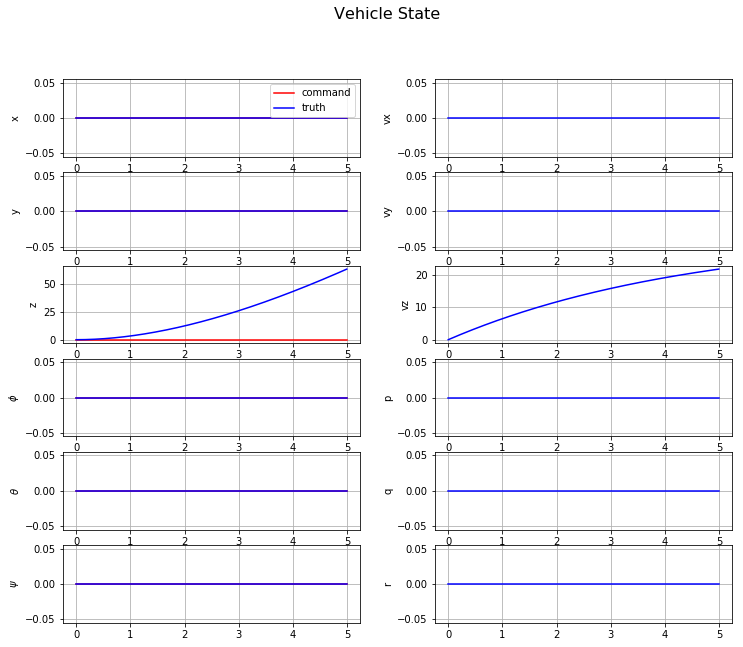

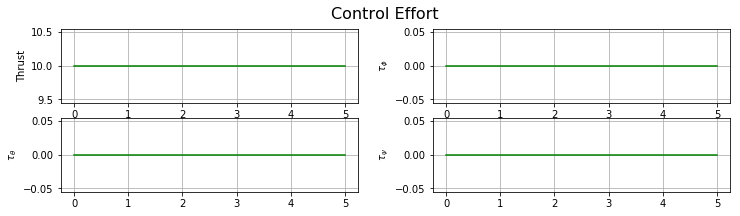

Quadrotor state after 500 iters:
	r:     [[ 0.000  0.000  63.880]].T
	Phi:   [[ 0.000  0.000  0.000]].T
	v:     [[ 0.000  0.000  21.651]].T
	omega: [[ 0.000  0.000  0.000]].T



In [7]:
sim = Simulator()
sim.run(5, Ts=0.01)
sim.plot()

print(sim.quad)